<a href="https://colab.research.google.com/github/MansiPandey-2002/DSA/blob/main/Product_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install vaderSentiment
!pip install wordcloud



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from textblob  import TextBlob #parts of speech in nlp/polarity/subject
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)


nltk.download('vader_lexicon')



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df=pd.read_csv('drive/MyDrive/amazon.csv')
df=df.sort_values('wilson_lower_bound',ascending=False)
df.drop('Unnamed: 0',inplace=True,axis=1)
df.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,"Hyoun Kim ""Faluzure""",5,[[ UPDATE - 6/19/2014 ]]So my lovely wife boug...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544
3449,NLee the Engineer,5,I have tested dozens of SDHC and micro-SDHC ca...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519
4212,SkincareCEO,1,NOTE: please read the last update (scroll to ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139
317,"Amazon Customer ""Kelly""",1,"If your card gets hot enough to be painful, it...",09-02-2012,1033,422,73,495,349,0.852525,0.818577
4672,Twister,5,Sandisk announcement of the first 128GB micro ...,03-07-2014,158,45,4,49,41,0.918367,0.808109


In [ ]:
def analyze_missing_values(df):
    # columns with missing
    columns_with_na = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_counts = df[columns_with_na].isnull().sum().sort_values() #num of missing

    missing_ratios = (missing_counts / df.shape[0] * 100).sort_values() #percentage of missing values

    # Combine the counts and ratios
    missing_summary = pd.concat([missing_counts, missing_ratios.round(2)], axis=1, keys=['Missing Values', 'Percentage'])
    return missing_summary

miss=analyze_missing_values(df)
miss


,Missing Values,Percentage
reviewerName,1,0.02
reviewText,1,0.02


In [ ]:
def dataframe_check(df,head=4,tail=4):
  print("SHAPE".center(82, '~')) #width and padding
  print('Rows: {}'.format(df.shape[0]))
  print('Columns: {}'.format(df.shape[1]))
  print("TYPES".center(82, '~'))
  print(df.dtypes)
  print("MISSING VALUES".center(82, '~'))
  print(analyze_missing_values(df))
  print('DUPLICATED VALUES'.center(83, '~'))
  print(df.duplicated().sum())
  print("QUANTILES".center(82, '~'))
  numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
  if not numeric_columns.empty:
      quantiles = df[numeric_columns].quantile([0.05, 0.50, 0.95, 0.99, 1]).T #/ dataset into 5
      print(quantiles)
  else:
      print("No numeric columns found to compute quantiles.")

dataframe_check(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 4915
Columns: 11
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
reviewerName             object
overall                   int64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~MISSING VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              Missing Values  Percentage
reviewerName               1        0.02
reviewText                 1        0.02
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~QUANTILES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                      0.05   0.50        0.95       0.99         1.00


In [ ]:
def remove_missing_values(df, axis=0, inplace=False):
    if axis == 0:
        df.dropna(axis=0, inplace=inplace)
    elif axis == 1:
        df.dropna(axis=1, inplace=inplace)
    else:
        raise ValueError("Axis must be 0 (rows) or 1 (columns).")

    if not inplace:
        return df


remove_missing_values(df, axis=0, inplace=True)  # Removes rows with missing values in place
dataframe_check(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~SHAPE~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 4913
Columns: 11
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~TYPES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
reviewerName             object
overall                   int64
reviewText               object
reviewTime               object
day_diff                  int64
helpful_yes               int64
helpful_no                int64
total_vote                int64
score_pos_neg_diff        int64
score_average_rating    float64
wilson_lower_bound      float64
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~MISSING VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~DUPLICATED VALUES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~QUANTILES~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                      0.05   0.50        0.95       0.99         1.00
overall                2.0    5.0    5.000000    5.00000   

In [ ]:
def check_class(dataframe):
    nunique_df = pd.DataFrame({
        'Variable': dataframe.columns,
        'Classes': [dataframe[i].nunique() for i in dataframe.columns]
    })

    # highest unique val col first
    nunique_df = nunique_df.sort_values('Classes', ascending=False)

    # Reset index with drop=true to drop prev index
    nunique_df = nunique_df.reset_index(drop=True)

    return nunique_df
check_class(df)

,Variable,Classes
0,reviewText,4912
1,reviewerName,4593
2,reviewTime,689
3,day_diff,689
4,wilson_lower_bound,40
5,score_average_rating,28
6,score_pos_neg_diff,27
7,total_vote,26
8,helpful_yes,23
9,helpful_no,17


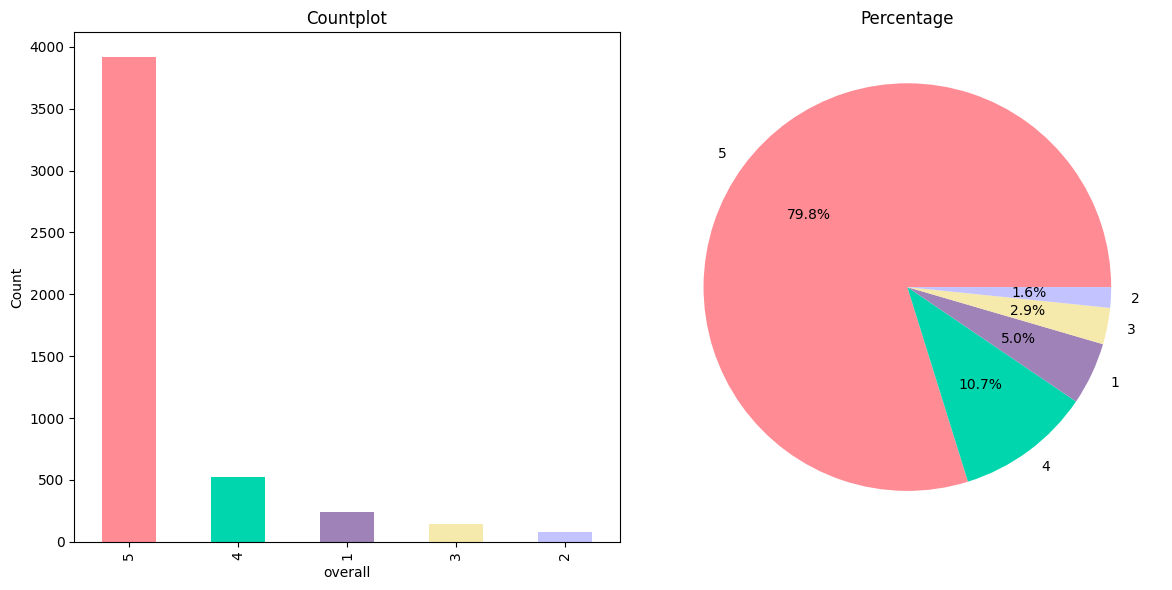

In [ ]:
constraints = ['#ff8b94', '#00d6ad', '#9f83b8', '#f6e9ac', '#c2c3ff']

def categorical_variable_summary(df, column_name):
    #two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) #1 row 2 col

    # Plot 1: Bar plot
    df[column_name].value_counts().plot(kind='bar', ax=ax1, color=constraints)
    ax1.set_title('Countplot')
    ax1.set_xlabel(column_name)
    ax1.set_ylabel('Count')

    # Plot 2: Pie chart
    ax2.pie(df[column_name].value_counts(), labels=df[column_name].value_counts().index, autopct='%1.1f%%', colors=constraints)
    ax2.set_title('Percentage')

    # Display the plot
    plt.tight_layout() #avoid overlap of subplots,clean visuals
    plt.show()

categorical_variable_summary(df, 'overall')


##Testing

In [ ]:
review_sample=df.reviewText[3449]
review_sample #original
#now using regex to clean any punctuation/space
review_sample=re.sub("[^a-zA-Z]",'',review_sample)
review_sample=review_sample.lower().split()
rt=lambda x:re.sub("[^a-zA-Z]",' ',str(x))
df["reviewText"]=df["reviewText"].map(rt)
df["reviewText"]=df["reviewText"].str.lower()
df.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
2031,"Hyoun Kim ""Faluzure""",5,update so my lovely wife boug...,05-01-2013,702,1952,68,2020,1884,0.966337,0.957544
3449,NLee the Engineer,5,i have tested dozens of sdhc and micro sdhc ca...,26-09-2012,803,1428,77,1505,1351,0.948837,0.936519
4212,SkincareCEO,1,note please read the last update scroll to ...,08-05-2013,579,1568,126,1694,1442,0.925620,0.912139
317,"Amazon Customer ""Kelly""",1,if your card gets hot enough to be painful it...,09-02-2012,1033,422,73,495,349,0.852525,0.818577
4672,Twister,5,sandisk announcement of the first gb micro ...,03-07-2014,158,45,4,49,41,0.918367,0.808109


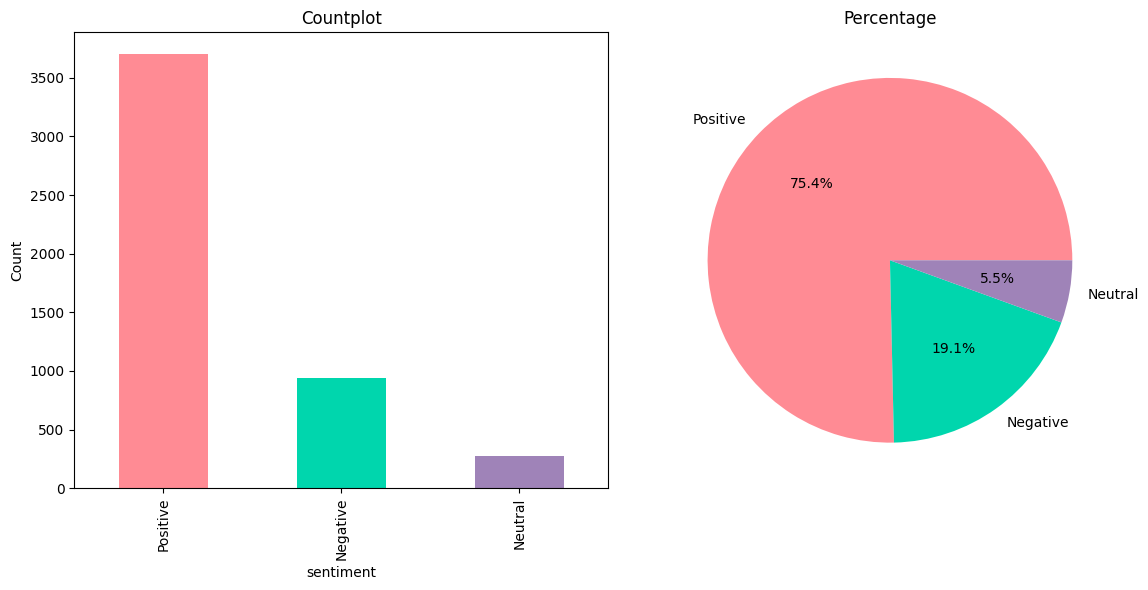

In [ ]:
# Define the sentiment analysis function
def analyze_sentiment(review):
    analyzer = SentimentIntensityAnalyzer()
    score = analyzer.polarity_scores(review)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']

    if neg > pos:
        return "Negative"
    elif pos > neg:
        return "Positive"
    else:
        return "Neutral"




df[['polarity', 'subjectivity']] = df['reviewText'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))  #polarity->-/+

# creating 'sentiment' column
df['sentiment'] = df['reviewText'].apply(analyze_sentiment)

#top 5 non-positive reviews
top_non_positive_reviews = df[df['sentiment'] != 'Positive'].sort_values('wilson_lower_bound', ascending=False).head(5)
top_non_positive_reviews
# Generate the categorical variable summary for the 'sentiment' column
categorical_variable_summary(df, 'sentiment')



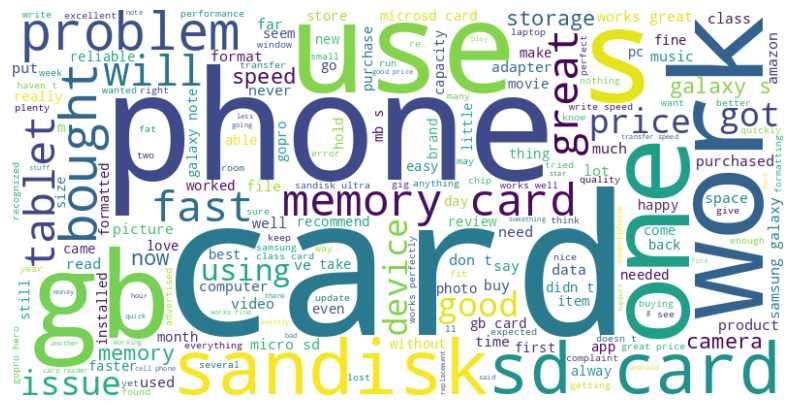

In [ ]:
# Combine all reviews into a single string (if needed)
all_reviews = ' '.join(df['reviewText'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Display the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
